In [0]:
!pip install -q tensorflow-gpu==2.0.0-alpha0

     |████████████████████████████████| 332.1MB 41kB/s 
     |████████████████████████████████| 3.0MB 37.2MB/s 
     |████████████████████████████████| 419kB 53.6MB/s 
     |████████████████████████████████| 61kB 27.5MB/s 


In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.models import model_from_json
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8401535104183819998
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 10715006038600862921
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17523788438415189805
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14892338381
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15303952657216504972
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [0]:
train = pd.read_csv('sign_mnist_train.csv')
test = pd.read_csv('sign_mnist_test.csv')

In [0]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,156,158,160,163,165,159,166,168,170,170,171,171,171,172,171,171,170,170,169,111,121,129,135,141,144,148,151,154,157,160,...,205,206,206,207,207,206,206,204,205,204,203,202,142,151,160,172,196,188,188,190,135,96,86,77,77,79,176,205,207,207,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,157,158,156,154,154,153,152,151,149,149,148,147,146,144,142,143,138,92,108,158,159,159,159,160,160,160,160,160,160,160,...,100,78,120,157,168,107,99,121,133,97,95,120,135,116,95,79,69,86,139,173,200,185,175,198,124,118,94,140,133,84,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,186,185,185,185,184,184,184,181,181,179,179,179,178,178,109,52,66,77,83,188,189,189,188,188,189,188,188,188,188,187,...,203,204,203,201,200,200,199,198,196,195,194,193,198,166,132,114,89,74,79,77,74,78,132,188,210,209,206,205,204,203,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,211,209,207,208,207,206,203,202,201,200,198,197,195,192,197,171,51,52,54,212,213,215,215,212,212,213,212,212,211,211,...,247,242,233,231,230,229,227,225,223,221,220,216,58,51,49,50,57,60,17,15,18,17,19,1,159,255,237,239,237,236,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,186,188,189,189,190,191,189,190,190,187,190,192,193,191,191,192,192,194,194,166,169,172,174,177,180,182,185,186,187,190,...,90,77,88,117,123,127,129,134,145,152,156,179,105,106,105,104,104,104,175,199,178,152,136,130,136,150,118,92,85,76,92,105,105,108,133,163,157,163,164,179


In [0]:
train.shape
labels = train['label'].values
unique_val = np.array(labels)
np.unique(unique_val)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])

In [0]:
train.shape

(27455, 785)

In [0]:
labels

array([ 3,  6,  2, ..., 18, 17, 23])

In [0]:
train.drop('label', axis = 1, inplace = True)
images = train.values
images = np.array([np.reshape(i, (28, 28)) for i in images])
images = np.array([i.flatten() for i in images])

In [0]:
label_binrizer = LabelBinarizer()
labels = label_binrizer.fit_transform(labels)
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.3, random_state = 101)

In [0]:
batch_size = 128
num_classes = 24
epochs = 50

x_train = x_train / 255
x_test = x_test / 255

In [0]:
x_train_t = np.stack([x_train.reshape(x_train.shape[0],28,28)]*3, axis=3).reshape(x_train.shape[0],28,28,3)
x_test_t = np.stack([x_test.reshape(x_test.shape[0],28,28)]*3, axis=3).reshape(x_test.shape[0],28,28,3)
x_train_t.shape, x_test_t.shape

((19218, 28, 28, 3), (8237, 28, 28, 3))

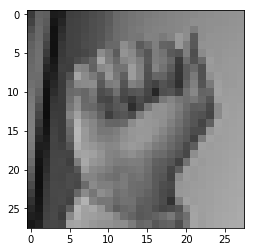

In [0]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
plt.imshow(x_train_t[0].reshape(28,28,3))

In [0]:
x_train_tt = np.asarray([img_to_array(array_to_img(im, scale=True).resize((48,48))) for im in x_train_t])/225
x_test_tt = np.asarray([img_to_array(array_to_img(im, scale=True).resize((48,48))) for im in x_test_t])/225
x_train_tt.shape, x_test_tt.shape

((19218, 48, 48, 3), (8237, 48, 48, 3))

W0515 15:20:45.915380 140543004833664 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


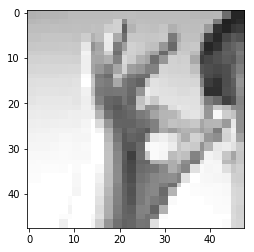

In [0]:
plt.imshow(x_test_tt[0].reshape(48,48,3))

In [0]:
conv_base = VGG19(weights='imagenet',include_top=False, input_shape=(48, 48, 3))

80142336/80134624 [==============================] - 13s 0us/step


In [0]:
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

In [0]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

In [0]:
model.layers[0].trainable = False
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 1, 1, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               3

In [0]:
TARGET_SHAPE = 48
BATCH_SIZE = 32

image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

image_gen_train.fit(x_train_tt)
val_data_gen = image_gen_train.flow(x_train_tt, y_train, BATCH_SIZE)

# Validation data should not be augmented!
image_gen_val = ImageDataGenerator(rescale=1./255)
image_gen_val.fit(x_test_tt)
val_data_gen = image_gen_val.flow(x_test_tt, y_test, BATCH_SIZE)

In [0]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [0]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

# Now is a good time for a cup of coffee
history = model.fit_generator(
      train_data_gen,
      steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
      epochs=EPOCHS,
      validation_data=val_data_gen,
      validation_steps=int(np.ceil(total_val / float(BATCH_SIZE))),
      verbose=2)

Train on 19218 samples, validate on 8237 samples
Epoch 1/50
19218/19218 [==============================] - 12s 634us/sample - loss: 1.3848 - accuracy: 0.6167 - val_loss: 0.5607 - val_accuracy: 0.8915
Epoch 2/50
19218/19218 [==============================] - 7s 388us/sample - loss: 0.4856 - accuracy: 0.8684 - val_loss: 0.2776 - val_accuracy: 0.9507
Epoch 3/50
19218/19218 [==============================] - 8s 394us/sample - loss: 0.2832 - accuracy: 0.9317 - val_loss: 0.1645 - val_accuracy: 0.9756
Epoch 4/50
19218/19218 [==============================] - 8s 393us/sample - loss: 0.1824 - accuracy: 0.9618 - val_loss: 0.1023 - val_accuracy: 0.9853
Epoch 5/50
19218/19218 [==============================] - 8s 393us/sample - loss: 0.1309 - accuracy: 0.9739 - val_loss: 0.0730 - val_accuracy: 0.9890
Epoch 6/50
19218/19218 [==============================] - 8s 394us/sample - loss: 0.0971 - accuracy: 0.9811 - val_loss: 0.0491 - val_accuracy: 0.9950
Epoch 7/50
19218/19218 [==========================

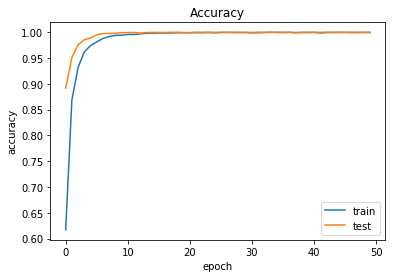

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','test'])
plt.show()

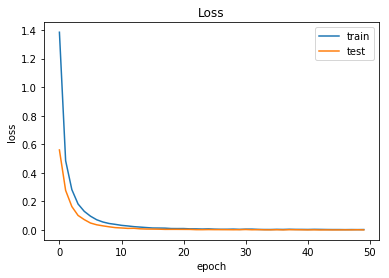

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','test'])
plt.show()

In [0]:
test_labels = test['label']

In [0]:
test.drop('label', axis = 1, inplace = True)

In [0]:
test_images = test.values
test_images = np.array([np.reshape(i, (28, 28)) for i in test_images])
#test_images = np.array([i.flatten() for i in test_images])
test_images_t = np.stack([test_images.reshape(test_images.shape[0],28,28)]*3, axis=3).reshape(test_images.shape[0],28,28,3)

# Resize the images 48*48 as required by VGG16
test_images_tt = np.asarray([img_to_array(array_to_img(im, scale=True).resize((48,48))) for im in test_images_t])/225
test_images_tt.shape

(7172, 48, 48, 3)

W0515 02:30:25.028413 140235939751808 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


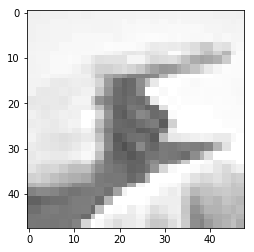

In [0]:
plt.imshow(test_images_tt[0].reshape(48,48,3))

In [0]:
test_labels = label_binrizer.fit_transform(test_labels)
test_images = test_images_tt.reshape(test_images.shape[0], 48, 48, 3)
test_images.shape

(7172, 48, 48, 3)

In [0]:
y_pred = model.predict(test_images)

In [0]:
from sklearn.metrics import accuracy_score

In [0]:
accuracy_score(test_labels, y_pred.round())

0.9537088678192973

In [0]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

In [0]:
tf.contrib.saved_model.save_keras_model(
    model,
    saved_model_path,
    custom_objects=None,
    as_text=None,
    input_signature=None,
    serving_only=False
)

tf.control_dependencies